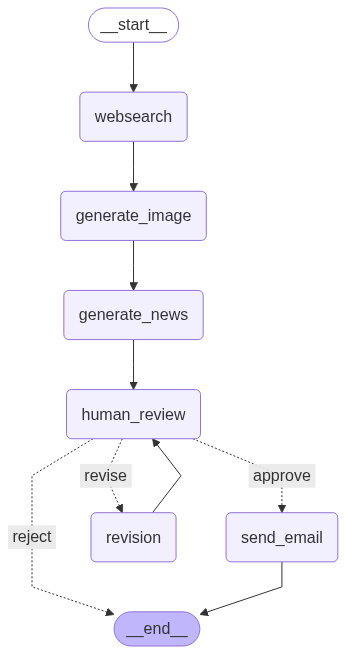

🚀 ເລີ່ມຕົ້ນການສ້າງຂ່າວພ້ອມຮູບພາບທີ່ກວດສອບແລ້ວສຳລັບ: สรุป Google I/O 2025
🔍 ກຳລັງຄົ້ນຫາຂໍ້ມູນສຳລັບ: สรุป Google I/O 2025
✅ ພົບຂໍ້ມູນ 5 ລາຍການ
🖼️ ກຳລັງຄົ້ນຫາ ແລະ ດາວໂຫລດຮູບ...
🔍 ພົບຮູບ 10 ຮູບຈາກ Serper
📋 ເລືອກ 8 ຮູບສຳລັບການດາວໂຫລດ
🔍 ກວດສອບ URL: https://cdn.marketingoops.com/wp-content/uploads/2025/05/Google-I-O-2025.png...
🔍 ກວດສອບ URL: https://images.droidsans.com/wp-content/uploads/2025/05/Google-IO-2025-COVER-1085x568.png...
🔍 ກວດສອບ URL: https://www.tangerine.co.th/wp-content/uploads/2025/05/%E0%B8%AA%E0%B8%A3%E0%B8%B8%E0%B8%9B-Google-I...
🔍 ກວດສອບ URL: https://www.enterpriseitpro.net/wp-content/uploads/2025/05/highlight-google-io-2025.jpg...
✅ URL ຜ່ານການກວດສອບ, ກຳລັງດາວໂຫລດ...
✅ URL ຜ່ານການກວດສອບ, ກຳລັງດາວໂຫລດ...
✅ ດາວໂຫລດສຳເລັດ: 96KB
🔍 ກວດສອບ URL: https://www.techmoblog.com/uploads/fbimg/2025/fbimg_1747832691880060.jpg...
✅ [1/8] ດາວໂຫລດສຳເລັດ: บทสรุป Google I/O 2025: มัดรวมทุกสิ่งที่คุณควรต้อง...
✅ URL ຜ່ານການກວດສອບ, ກຳລັງດາວໂຫລດ...
✅ URL ຜ່ານການກວດສອບ, ກຳລັງດາວໂຫລດ...
✅ ດາວໂຫລດສ

In [16]:
import http.client
import json
import smtplib  
import concurrent.futures
from typing import Dict, Any, List
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
from datetime import datetime
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict 
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display 
import markdown
import requests
from io import BytesIO
import base64
from PIL import Image as PILImage
load_dotenv()
import os 

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["CLAUDE_API_KEY"]=os.getenv("CLAUDE_API_KEY") 
os.environ["SERPAPI_API_KEY2"]=os.getenv("SERPAPI_API_KEY2")

# Configuration
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
SMTP_EMAIL = os.getenv("SMTP_EMAIL", "")
SMTP_PASSWORD = os.getenv("SMTP_PASSWORD", "")

class NewsState(TypedDict):
    topic: str
    search_results: List[Dict[str, Any]]
    image_results: List[Dict[str, Any]]
    downloaded_images: List[Dict[str, Any]]
    news_content: str
    human_feedback: str
    approval_status: str
    messages: Annotated[list, add_messages]

class NewsGenerator:
    def __init__(self):
        self.llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", temperature=0.7, max_tokens=4000, api_key=os.getenv("CLAUDE_API_KEY"))
        self.tavily = TavilySearchResults()
        self.serper_api_key = os.getenv("SERPAPI_API_KEY2")
        self.setup_graph()
    
    def setup_graph(self):
        """ສ້າງ LangGraph workflow"""
        workflow = StateGraph(NewsState)
        
        # ເພີ່ມ nodes
        workflow.add_node("websearch", self.websearch_node)
        workflow.add_node("generate_image", self.generate_image_node)
        workflow.add_node("generate_news", self.generate_news_node)
        workflow.add_node("human_review", self.human_review_node)
        workflow.add_node("send_email", self.send_email_node)
        workflow.add_node("revision", self.revision_node)
        
        # ກຳນົດ workflow - ເຮັດ parallel
        workflow.set_entry_point("websearch")
        workflow.add_edge("websearch", "generate_image")
        workflow.add_edge("generate_image", "generate_news")
        workflow.add_edge("generate_news", "human_review")
        
        # Conditional routing ຈາກ human review
        workflow.add_conditional_edges(
            "human_review",
            self.should_approve,
            {
                "approve": "send_email",
                "revise": "revision",
                "reject": END
            }
        )
        
        workflow.add_edge("revision", "human_review")
        workflow.add_edge("send_email", END)
        
        self.app = workflow.compile()
        display(Image(self.app.get_graph().draw_mermaid_png()))

    def search_images(self, query: str) -> List[Dict[str, Any]]:
        """ຄົ້ນຫາຮູບຈາກ Serper API"""
        try:
            conn = http.client.HTTPSConnection("google.serper.dev")
            payload = json.dumps({"q": query})
            headers = {
                'X-API-KEY': self.serper_api_key,
                'Content-Type': 'application/json'
            }
            
            conn.request("POST", "/images", payload, headers)
            res = conn.getresponse()
            data = res.read()
            conn.close()
            
            # Parse JSON response ຕາມ format ທີ່ເຈົ້າໃຫ້ມາ
            result = json.loads(data.decode("utf-8"))
            return result.get("images", [])
            
        except Exception as e:
            print(f"❌ ຜິດພາດໃນການຄົ້ນຫາຮູບ: {e}")
            return []

    def is_valid_image_url(self, url: str) -> bool:
        """ກວດສອບວ່າ URL ເປັນຮູບພາບແທ້ຫຼືບໍ່"""
        try:
            # ກວດສອບ extension ກ່ອນ
            valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']
            url_lower = url.lower()
            
            # ບາງ URL ບໍ່ມີ extension ແຕ່ເປັນ API ຮູບ
            has_extension = any(ext in url_lower for ext in valid_extensions)
            is_image_api = any(keyword in url_lower for keyword in [
                'img', 'image', 'photo', 'pic', 'media', 'cdn'
            ])
            
            if not has_extension and not is_image_api:
                return False
            
            # ທຳການ HEAD request ເພື່ອກວດສອບ Content-Type
            response = requests.head(url, timeout=5, headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            })
            
            if response.status_code == 200:
                content_type = response.headers.get('Content-Type', '').lower()
                return content_type.startswith('image/')
            
            return False
            
        except Exception as e:
            print(f"⚠️ ບໍ່ສາມາດກວດສອບ URL {url}: {e}")
            return False

    def verify_image_content(self, image_data: bytes) -> bool:
        """ກວດສອບວ່າ data ທີ່ດາວໂຫລດມາເປັນຮູບແທ້ຫຼືບໍ່"""
        try:
            # ໃຊ້ PIL ເພື່ອກວດສອບ
            PILImage.open(BytesIO(image_data))
            return True
        except Exception:
            return False

    def download_image(self, image_info: Dict[str, Any]) -> Dict[str, Any]:
        """ດາວໂຫລດຮູບຈາກ imageUrl ພ້ອມການກວດສອບ"""
        try:
            # ເອົາ imageUrl ຈາກ response format ທີ່ເຈົ້າໃຫ້ມາ
            url = image_info.get('imageUrl', '')
            if not url:
                print(f"⚠️ ບໍ່ມີ imageUrl ສຳລັບ: {image_info.get('title', 'Unknown')}")
                return None
            
            print(f"🔍 ກວດສອບ URL: {url[:100]}...")
            
            # ກວດສອບວ່າ URL ເປັນຮູບແທ້ຫຼືບໍ່
            if not self.is_valid_image_url(url):
                print(f"❌ URL ບໍ່ແມ່ນຮູບພາບ: {url[:50]}...")
                return None
            
            print(f"✅ URL ຜ່ານການກວດສອບ, ກຳລັງດາວໂຫລດ...")
            
            # ດາວໂຫລດຮູບ
            response = requests.get(url, timeout=15, headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Referer': 'https://www.google.com/',
                'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8'
            })
            
            if response.status_code == 200:
                image_data = response.content
                
                # ກວດສອບວ່າ data ເปັນຮູບແທ້ຫຼືບໍ່
                if not self.verify_image_content(image_data):
                    print(f"❌ ຂໍ້ມູນທີ່ດາວໂຫລດມາບໍ່ແມ່ນຮູບພາບ")
                    return None
                
                # ກວດສອບຂະໜາດຮູບ
                if len(image_data) < 1024:  # ນ້ອຍກວ່າ 1KB
                    print(f"❌ ຮູບນ້ອຍເກີນໄປ: {len(image_data)} bytes")
                    return None
                
                if len(image_data) > 10 * 1024 * 1024:  # ໃຫຍ່ກວ່າ 10MB
                    print(f"⚠️ ຮູບໃຫຍ່ເກີນໄປ: {len(image_data)//1024//1024}MB, ຂ້າມ")
                    return None
                
                # ແປງເປັນ base64 ສຳລັບການສົ່ງ email
                image_base64 = base64.b64encode(image_data).decode('utf-8')
                
                result = {
                    "title": image_info.get('title', 'No title'),
                    "url": url,
                    "link": image_info.get('link','Unknown'),
                    "source": image_info.get('source', 'Unknown'),
                    "width": image_info.get('imageWidth', 0),
                    "height": image_info.get('imageHeight', 0),
                    "data": image_data,
                    "base64": image_base64,
                    "size": len(image_data),
                    "position": image_info.get('position', 0)
                }
                
                print(f"✅ ດາວໂຫລດສຳເລັດ: {len(image_data)//1024}KB")
                return result
            else:
                print(f"❌ HTTP Error {response.status_code}")
                return None
                
        except requests.exceptions.Timeout:
            print(f"❌ Timeout ໃນການດາວໂຫລດ: {url[:50]}...")
            return None
        except requests.exceptions.RequestException as e:
            print(f"❌ Request error: {e}")
            return None
        except Exception as e:
            print(f"❌ ບໍ່ສາມາດດາວໂຫລດຮູບ {url[:50]}...: {e}")
            return None

    def generate_image_node(self, state: NewsState) -> NewsState:
        """ຄົ້ນຫາ ແລະ ດາວໂຫລດຮູບແບບ parallel ພ້ອມການກວດສອບ"""
        print("🖼️ ກຳລັງຄົ້ນຫາ ແລະ ດາວໂຫລດຮູບ...")
        
        try:
            # ຄົ້ນຫາຮູບ
            image_results = self.search_images(state['topic'])
            state['image_results'] = image_results
            
            if not image_results:
                print("⚠️ ບໍ່ພົບຮູບສຳລັບຫົວຂໍ້ນີ້")
                state['downloaded_images'] = []
                return state
            
            print(f"🔍 ພົບຮູບ {len(image_results)} ຮູບຈາກ Serper")
            
            # ເລືອກຮູບທີ່ດີທີ່ສຸດ 8 ຮູບແຮກ (ເພີ່ມເປັນ 8 ເພາະບາງຮູບອາດຈະດາວໂຫລດບໍ່ໄດ້)
            selected_images = image_results[:8]
            
            print(f"📋 ເລືອກ {len(selected_images)} ຮູບສຳລັບການດາວໂຫລດ")
            
            # ດາວໂຫລດຮູບແບບ parallel ໃຊ້ ThreadPoolExecutor
            downloaded_images = []
            with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
                # ສົ່ງ tasks ໄປຫາ thread pool
                future_to_image = {
                    executor.submit(self.download_image, img): img 
                    for img in selected_images
                }
                
                # ເກັບຜົນລັບ
                completed_count = 0
                for future in concurrent.futures.as_completed(future_to_image, timeout=60):
                    completed_count += 1
                    try:
                        result = future.result()
                        if result:
                            downloaded_images.append(result)
                            print(f"✅ [{completed_count}/{len(selected_images)}] ດາວໂຫລດສຳເລັດ: {result['title'][:50]}...")
                        else:
                            print(f"❌ [{completed_count}/{len(selected_images)}] ດາວໂຫລດບໍ່ສຳເລັດ")
                    except Exception as e:
                        print(f"❌ [{completed_count}/{len(selected_images)}] Error: {e}")
                
                # ຖ້າມີຮູບໜ້ອຍເກີນໄປ
                if len(downloaded_images) < 2 and len(image_results) > 8:
                    print("🔄 ພະຍາຍາມດາວໂຫລດຮູບເພີ່ມເຕີມ...")
                    additional_images = image_results[8:15]  # ເອົາ 7 ຮູບຕໍ່ໄປ
                    
                    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor2:
                        future_to_image2 = {
                            executor2.submit(self.download_image, img): img 
                            for img in additional_images
                        }
                        
                        for future in concurrent.futures.as_completed(future_to_image2, timeout=45):
                            result = future.result()
                            if result and len(downloaded_images) < 5:
                                downloaded_images.append(result)
                                print(f"✅ ດາວໂຫລດເພີ່ມເຕີມສຳເລັດ: {result['title'][:50]}...")
            
            # ຈັດລຽງຮູບຕາມ position
            downloaded_images.sort(key=lambda x: x.get('position', 999))
            
            state['downloaded_images'] = downloaded_images
            print(f"🎉 ດາວໂຫລດສຳເລັດທັງຫມົດ {len(downloaded_images)} ຮູບ")
            
            if downloaded_images:
                total_size = sum(img['size'] for img in downloaded_images)
                print(f"📊 ຂະໜາດລວມ: {total_size//1024//1024}MB")
            
        except Exception as e:
            print(f"❌ ຜິດພາດໃນການຄົ້ນຫາຮູບ: {e}")
            state['image_results'] = []
            state['downloaded_images'] = []
        
        state['messages'].append(HumanMessage(content=f"ຄົ້ນຫາ ແລະ ດາວໂຫລດຮູບສຳລັບ: {state['topic']}"))
        return state
    
    def websearch_node(self, state: NewsState) -> NewsState:
        """ຄົ້ນຫາຂໍ້ມູນຈາກເວັບໂດຍໃຊ້ Tavily"""
        print(f"🔍 ກຳລັງຄົ້ນຫາຂໍ້ມູນສຳລັບ: {state['topic']}")
        
        try:
            # ໃຊ້ Tavily search
            search_results = self.tavily.run(state['topic'])
            
            # ແປງຜົນການຄົ້ນຫາຈາກ Tavily ໃຫ້ເປັນຮູບແບບທີ່ເຮົາຕ້ອງການ
            formatted_results = []
            
            if isinstance(search_results, list):
                for result in search_results:
                    if isinstance(result, dict):
                        formatted_result = {
                            "title": result.get("title", "No title"),
                            "content": result.get("content", result.get("snippet", "")),
                            "url": result.get("url", ""),
                            "published": result.get("published_date", "")
                        }
                        formatted_results.append(formatted_result)
            else:
                # ຖ້າຜົນການຄົ້ນຫາເປັນ string
                formatted_results = [{
                    "title": f"Search results for {state['topic']}",
                    "content": str(search_results),
                    "url": "",
                    "published": datetime.now().isoformat()
                }]
            
            state['search_results'] = formatted_results
            print(f"✅ ພົບຂໍ້ມູນ {len(formatted_results)} ລາຍການ")
            
        except Exception as e:
            print(f"❌ ຜິດພາດໃນການຄົ້ນຫາ: {e}")
            # ໃຊ້ຂໍ້ມູນສຳຮອງ
            state['search_results'] = [{
                "title": f"Error searching for {state['topic']}",
                "content": f"Unable to search for information about {state['topic']} due to: {str(e)}",
                "url": "",
                "published": datetime.now().isoformat()
            }]
        
        state['messages'].append(HumanMessage(content=f"ຄົ້ນຫາຂໍ້ມູນສຳລັບ: {state['topic']}"))
        return state
    
    def generate_news_node(self, state: NewsState) -> NewsState:
        """ສ້າງຂ່າວຈາກຂໍ້ມູນທີ່ຄົ້ນຫາໄດ້ ແລະ ຮູບພາບທີ່ກວດສອບແລ້ວ"""
        print("📝 ກຳລັງສ້າງຂ່າວພ້ອມຮູບພາບທີ່ກວດສອບແລ້ວ...")
        
        # ສ້າງ prompt ສຳລັບການສ້າງຂ່າວ
        prompt = ChatPromptTemplate.from_messages([
            ("system", """ທ່ານເປັນນັກຂ່າວມືອາຊີບທີ່ມີປະສົບການ. ກະລຸນາສ້າງບົດຂ່າວທີ່ມີຄຸນນະພາບສູງ ໂດຍປະຕິບັດຕາມຫຼັກຈັນຍາບັນຂອງວາລະສານສຳນັກຂ່າວມາດຕະຖານ:

        1. ໃຊ້ພາສາລາວທີ່ຊັດເຈນ, ຖືກຕ້ອງ ແລະ ເໝາະສົມກັບສຳນັກຂ່າວ
        2. ລາຍງານຕາມຄວາມເປັນຈິງ ໂດຍການກວດສອບຂໍ້ມູນຢ່າງລະມັດລະວັງ
        3. ຈັດລຽງໂຄງສ້າງຂ່າວແບບປະຕິບັດຕົວຈິງ (Inverted Pyramid)
        4. ຖ້າຂໍ້ມູນບໍ່ພຽງພໍ ຫຼື ມີຂໍ້ມູນທີ່ຍັງບໍ່ຊັດເຈນ ຕ້ອງລະບຸໄວ້ຢ່າງຊັດເຈນ
        5. ປະກອບດ້ວຍຂໍ້ມູນທີ່ສາມາດກວດສອບໄດ້ ແລະ ແຫຼ່ງຂໍ້ມູນທີ່ໜ້າເຊື່ອຖື
        6. ເມື່ອມີຮູບພາບປະກອບ ໃຫ້ອ້າງອີງເຖິງຮູບພາບໃນບົດຂ່າວ

        ໂຄງສ້າງບົດຂ່າວທີ່ດີ:
        - ຫົວຂໍ້ທີ່ດຶງດູດ ແລະ ສະຫຼຸບເນື້ອໃນຫຼັກ
        - ຍ່ອຍຫົວຂໍ້ (ຖ້າຈຳເປັນ)
        - ຂໍ້ຄວາມນຳ (Lead) ທີ່ສະຫຼຸບເນື້ອໃນສຳຄັນ
        - ເນື້ອໃນຫຼັກທີ່ມີລາຍລະອຽດ ແລະ ຂໍ້ມູນສະໜັບສະໜູນ
        - ຂໍ້ມູນພື້ນຖານ (5W1H)
        - ຄຳເຫັນຈາກຜູ້ກ່ຽວຂ້ອງ (ຖ້າມີ)
        - ສະຫຼຸບສັງລວມ (ຖ້າຈຳເປັນ)"""),
            ("human", """ຫົວຂໍ້ຂ່າວ: {topic}
            
        ຂໍ້ມູນທີ່ຄົ້ນພົບ:
        {search_results}

        ຮູບພາບທີ່ກວດສອບແລ້ວ:
        {image_info}

        ກະລຸນາສ້າງບົດຂ່າວທີ່ມີຄຸນນະພາບ ໂດຍ:
        1. ກວດສອບຄວາມຖືກຕ້ອງຂອງຂໍ້ມູນ
        2. ຈັດລຽງໂຄງສ້າງຕາມຫຼັກວາລະສານສຳນັກຂ່າວ
        3. ໃຊ້ພາສາທາງການທີ່ເໝາະສົມ
        4. ອ້າງອີງເຖິງຮູບພາບທີ່ກວດສອບແລ້ວ (ຖ້າມີ)""")
        ])
        
        # ແປງ search results ເປັນ string ທີ່ອ່ານງ່າຍ
        search_data = ""
        for i, result in enumerate(state['search_results'], 1):
            search_data += f"\n{i}. ຫົວຂໍ້: {result['title']}\n"
            search_data += f"   ເນື້ອຫາ: {result['content']}\n"
            if result['url']:
                search_data += f"   ແຫຼ່ງ: {result['url']}\n"
            if result['published']:
                search_data += f"   ວັນທີ່: {result['published']}\n"
            search_data += "\n"
        
        # ແປງຂໍ້ມູນຮູບເປັນ string
        image_info = ""
        if state.get('downloaded_images'):
            image_info = f"ມີຮູບພາບປະກອບທີ່ກວດສອບແລ້ວ {len(state['downloaded_images'])} ຮູບ:\n"
            for i, img in enumerate(state['downloaded_images'], 1):
                image_info += f"{i}. {img['title'][:100]}... \n"
                image_info += f"   - ຂະໜາດ: {img['width']}x{img['height']} pixels\n"
                image_info += f"   - ແຫຼ່ງ: {img['source']}\n"
                image_info += f"   - ຂະໜາດໄຟລ໌: {img['size']//1024}KB\n"
        else:
            image_info = "ບໍ່ມີຮູບພາບປະກອບທີ່ຜ່ານການກວດສອບ"
        
        try:
            # ສ້າງຂ່າວ
            response = self.llm.invoke(
                prompt.format_messages(
                    topic=state['topic'],
                    search_results=search_data,
                    image_info=image_info
                )
            )
            
            state['news_content'] = response.content
            state['messages'].append(AIMessage(content=f"ສ້າງຂ່າວພ້ອມຮູບພາບທີ່ກວດສອບແລ້ວສຳເລັດ"))
            print("✅ ສ້າງຂ່າວສຳເລັດ")
            
        except Exception as e:
            print(f"❌ ຜິດພາດໃນການສ້າງຂ່າວ: {e}")
            state['news_content'] = f"ຂໍອະໄພ, ບໍ່ສາມາດສ້າງຂ່າວສຳລັບຫົວຂໍ້ '{state['topic']}' ໄດ້ເນື່ອງຈາກມີຄວາມຜິດພາດທາງເທັກນິກ."
            state['messages'].append(AIMessage(content=f"ຜິດພາດໃນການສ້າງຂ່າວ: {e}"))
        
        return state
    
    def human_review_node(self, state: NewsState) -> NewsState:
        """ໃຫ້ມະນຸດກວດສອບ ແລະ ອະນຸມັດ"""
        print("\n" + "="*60)
        print("👤 HUMAN REVIEW REQUIRED")
        print("="*60)
        print(f"ຫົວຂໍ້: {state['topic']}")
        print(f"\nຂໍ້ມູນທີ່ພົບ: {len(state['search_results'])} ລາຍການ")
        print(f"ຮູບພາບທີ່ກວດສອບແລ້ວ: {len(state.get('downloaded_images', []))} ຮູບ")
        
        # ສະແດງຂໍ້ມູນຮູບ
        if state.get('downloaded_images'):
            print("\n🖼️ ຮູບພາບທີ່ຜ່ານການກວດສອບ:")
            for i, img in enumerate(state['downloaded_images'], 1):
                print(f"  {i}. {img['title'][:60]}...")
                print(f"     - ຂະໜາດ: {img['width']}x{img['height']} pixels")
                print(f"     - ແຫຼ່ງຂໍ້ມູນ: {img['link']}")
                print(f"     - ແຫຼ່ງ: {img['source']}")
                print(f"     - ໄຟລ໌: {img['size']//1024}KB")
                print(f"     - URL: {img['url'][:80]}...")
        
        print("\nຂ່າວທີ່ສ້າງ:")
        print("-" * 40)
        print(state['news_content'])
        print("-" * 40)
        
        print("\nOptions:")
        print("1. 'accept' - ອະນຸມັດ ແລະ ສົ່ງອີເມວ")
        print("2. 'revise' - ຂໍໃຫ້ປັບປຸງ")
        print("3. 'reject' - ປະຕິເສດ")
        
        while True:
            feedback = input("\nກະລຸນາໃຫ້ຄຳຕິຊົມ (accept/revise/reject): ").strip().lower()
            
            if feedback in ['accept', 'revise', 'reject']:
                state['human_feedback'] = feedback
                if feedback == 'revise':
                    revision_note = input("ກະລຸນາໃຫ້ຄຳແນະນຳການປັບປຸງ: ")
                    state['human_feedback'] += f": {revision_note}"
                break
            else:
                print("ກະລຸນາເລືອກ accept, revise, ຫຼື reject")
        
        state['messages'].append(HumanMessage(content=f"Human feedback: {state['human_feedback']}"))
        return state
    
    def revision_node(self, state: Dict[str, Any]) -> Dict[str, Any]:
        """ປັບປຸງຂ່າວຕາມຄຳແນະນຳ"""
        print("🔄 ກຳລັງປັບປຸງຂ່າວ...")
        
        revision_prompt = ChatPromptTemplate.from_messages([
            ("system", """ທ່ານເປັນບັນນາທິການຂ່າວມືອາຊີບ. ກະລຸນາປັບປຸງບົດຂ່າວດ້ວຍຫຼັກການດັ່ງນີ້:
1. ຮັກສາຄວາມເປັນຈິງ ແລະ ຄວາມຖືກຕ້ອງ
2. ໃຊ້ພາສາລາວທີ່ສະອາດ ແລະ ເໝາະສົມ
3. ຈັດໂຄງສ້າງຂ່າວໃຫ້ຊັດເຈນ
4. ຖ້າມີຂໍ້ມູນທີ່ບໍ່ຊັດເຈນ ຕ້ອງລະບຸໄວ້"""),
            ("human", """**ຂ່າວເດີມ:**
{original_news}

**ຄຳແນະນຳການປັບປຸງ:**
{feedback}

**ກະລຸນາປັບປຸງຂ່າວໃຫ້ດີຂຶ້ນ:**""")
        ])
        
        try:
            response = self.llm.invoke(
                revision_prompt.format_messages(
                    original_news=state.get('news_content', ''),
                    feedback=state.get('human_feedback', '')
                )
            )
            
            state['news_content'] = response.content
            state['messages'].append(AIMessage(content="✅ ປັບປຸງຂ່າວສຳເລັດ"))
            print("✅ ປັບປຸງຂ່າວສຳເລັດ")
            
        except Exception as e:
            error_msg = f"❌ ຜິດພາດໃນການປັບປຸງ: {str(e)}"
            print(error_msg)
            state['messages'].append(AIMessage(content=error_msg))
        
        return state
    
    def send_email_node(self, state: NewsState) -> NewsState:
        """Send verified news with images via email."""
        print("📧 Sending email with verified images...")

        try:
            # Create email
            msg = MIMEMultipart('related')
            msg['From'] = SMTP_EMAIL
            msg['To'] = "Nalinthorn-007@hotmail.com"
            msg['Subject'] = f"Automated News (Verified Images): {state['topic']}"

            # Convert Markdown to HTML
            news_html = markdown.markdown(state['news_content'])

            # Create HTML for images
            images_html = ""
            if state.get('downloaded_images'):
                images_html = '<div class="images-section"><h3>🖼️ Verified Images</h3>'
                for i, img in enumerate(state['downloaded_images']):
                    cid = f"image_{i}"
                    source_link = img.get('link', img.get('url', ''))
                    images_html += f'''
                    <div class="image-card">
                        <img src="cid:{cid}" alt="{img['title']}" class="image"/>
                        <div class="image-details">
                            <h4>{img['title']}</h4>
                            <p><strong>Source:</strong> {img['source']}</p>
                            <p><strong>Size:</strong> {img['width']}x{img['height']}px</p>
                            <p><strong>File:</strong> {img['size']//1024}KB</p>
                            {f'<a href="{source_link}" target="_blank" class="source-link">🔗 View Source</a>' if source_link else ''}
                        </div>
                    </div>
                    '''
                images_html += '</div>'

            # HTML template
            html_body = f"""
            <html>
            <head>
                <style>
                    @font-face {{
                        font-family: 'Phetsalath'; 
                    }}
                    body {{ font-family: 'Phetsalath', Arial, sans-serif; background-color: #f4f4f9; margin: 0; padding: 20px; }}
                    .images-section {{ margin: 20px 0; }}
                    .image-card {{
                        background: white;
                        border-radius: 8px;
                        box-shadow: 0 4px 8px rgba(0,0,0,0.1);
                        margin-bottom: 20px;
                        overflow: hidden;
                        transition: transform 0.3s ease;
                    }}
                    .image-card:hover {{ transform: translateY(-5px); }}
                    .image {{ width: 100%; height: auto; display: block; }}
                    .image-details {{ padding: 15px; }}
                    .image-details h4 {{ margin: 0 0 10px; color: #333; }}
                    .image-details p {{ margin: 5px 0; color: #555; }}
                    .source-link {{
                        display: inline-block;
                        margin-top: 10px;
                        padding: 8px 12px;
                        background-color: #007acc;
                        color: white;
                        text-decoration: none;
                        border-radius: 4px;
                        transition: background-color 0.3s ease;
                    }}
                    .source-link:hover {{ background-color: #005999; }}
                    footer {{
                        margin-top: 40px;
                        padding: 20px;
                        background-color: #007acc;
                        color: white;
                        text-align: center;
                        border-radius: 8px;
                    }}
                    footer p {{ margin: 5px 0; }}
                </style>
            </head>
            <body>
                <h1>🤖 Automated News</h1>
                <p><strong>Topic:</strong> {state['topic']}</p>
                <div>{news_html}</div>
                {images_html}
                <footer>
                    <p>Created on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                    <p>Created by: VIENTIANE AI News By NALINTHORN</p>
                </footer>
            </body>
            </html>
            """

            # Attach HTML content
            msg_alternative = MIMEMultipart('alternative')
            msg.attach(msg_alternative)
            msg_alternative.attach(MIMEText(html_body, 'html', 'utf-8'))

            # Attach images
            if state.get('downloaded_images'):
                for i, img in enumerate(state['downloaded_images']):
                    img_mime = MIMEImage(img['data'])
                    img_mime.add_header('Content-ID', f'<image_{i}>')
                    msg.attach(img_mime)

            # Send email
            if SMTP_EMAIL and SMTP_PASSWORD:
                server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
                server.starttls()
                server.login(SMTP_EMAIL, SMTP_PASSWORD)
                server.send_message(msg)
                server.quit()
                print(f"✅ Email sent successfully! ({len(state.get('downloaded_images', []))} images verified)")
                state['approval_status'] = 'sent'
            else:
                print("⚠️ Email credentials not set")
                print("HTML Email Preview:")
                print(html_body[:1000] + "...")
                state['approval_status'] = 'simulated'

        except Exception as e:
            print(f"❌ Error sending email: {e}")
            state['approval_status'] = 'failed'

        state['messages'].append(AIMessage(content=f"Email status: {state['approval_status']}"))
        return state
    
    def should_approve(self, state: NewsState) -> str:
        """ຕັດສິນໃຈວ່າຈະເຮັດຫຍັງຕໍ່ໄປ"""
        feedback = state['human_feedback'].lower()
        
        if feedback.startswith('accept'):
            return "approve"
        elif feedback.startswith('revise'):
            return "revise"
        else:
            return "reject"
    
    def run(self, topic: str):
        """ເລີ່ມຕົ້ນ workflow"""
        initial_state = NewsState(
            topic=topic,
            search_results=[],
            image_results=[],
            downloaded_images=[],
            news_content="",
            human_feedback="",
            approval_status="",
            messages=[]
        )
        
        print(f"🚀 ເລີ່ມຕົ້ນການສ້າງຂ່າວພ້ອມຮູບພາບທີ່ກວດສອບແລ້ວສຳລັບ: {topic}")
        
        # ເຮັດວຽກ workflow
        final_state = self.app.invoke(initial_state)
        
        print("\n" + "="*60)
        print("✅ WORKFLOW ສຳເລັດ")
        print("="*60)
        print(f"Status: {final_state.get('approval_status', 'unknown')}")
        print(f"Images found: {len(final_state.get('image_results', []))}")
        print(f"Images verified & downloaded: {len(final_state.get('downloaded_images', []))}")
        
        return final_state

# ການໃຊ້ງານ
if __name__ == "__main__": 
    generator = NewsGenerator()
    
    # ທົດສອບດ້ວຍຫົວຂໍ້
    topic = "สรุป Google I/O 2025"
    result = generator.run(topic)